# Tutorial on inference with approximate nearest neighbours search

RePlay models such as Word2Vec and ALS could return user or item vectors which could be used to find close items and get item2item recommendation or ret relevant items for user (ALS). Basic way to do so is to calculate the distance (e.g. cosine, negative dot product) between all available vectors and select top-k, but this calculation is computationally expensive. Other way is to use approximate methods.

There are many approximate nearest neighbours search methods and libraries (see [ANN benchmarks](http://ann-benchmarks.com/)).

We will use one of them to build index and make prediction for selected users. 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config Completer.use_jedi = False

In [5]:
from replay.session_handler import State

spark = State().session
spark

21/12/27 12:13:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/27 12:13:09 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
21/12/27 12:13:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/12/27 12:13:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
/home/volodkevich/replay_tasks/current_base/env39/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading an

In [6]:
spark.sparkContext.setLogLevel("ERROR")

In [7]:
K = 5
SEED=1234

## 0. Data preprocessing <a name='data-preparator'></a>
We will use the Million Song Dataset m as an example as it contains over 300'000 items.

In [8]:
# !pip install rs_datasets

In [9]:
%%time
from rs_datasets import MillionSongDataset
msd = MillionSongDataset()
msd.info()

train


,user_id,item_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2



val


,user_id,item_id,play_count
0,0007140a3796e901f3190f12e9de6d7548d4ac4a,SONVMBN12AC9075271,1
1,0007140a3796e901f3190f12e9de6d7548d4ac4a,SOVIGZG12A6D4FB188,1
2,0007140a3796e901f3190f12e9de6d7548d4ac4a,SOZGXYF12AB0185579,2



test


,user_id,item_id,play_count
0,00007a02388c208ea7176479f6ae06f8224355b3,SOAITVD12A6D4F824B,3
1,00007a02388c208ea7176479f6ae06f8224355b3,SONZGLW12A6D4FBBC1,1
2,00007a02388c208ea7176479f6ae06f8224355b3,SOXNWYP12A6D4FBDC4,1



CPU times: user 15min 56s, sys: 15.1 s, total: 16min 11s
Wall time: 2min 23s


### 0.1. DataPreparator

In [10]:
from replay.data_preparator import DataPreparator

log = DataPreparator().transform(
    data=msd.train,
    columns_names={
        "user_id": "user_id",
        "item_id": "item_id",
        "relevance": "play_count",
    }
)

In [11]:
log.show(3)

+--------------------+------------------+---------+-------------------+
|             user_id|           item_id|relevance|          timestamp|
+--------------------+------------------+---------+-------------------+
|b80344d063b5ccb32...|SOAKIMP12A8C130995|      1.0|1999-05-01 00:00:00|
|b80344d063b5ccb32...|SOAPDEY12A81C210A9|      1.0|1999-05-01 00:00:00|
|b80344d063b5ccb32...|SOBBMDR12A8C13253B|      2.0|1999-05-01 00:00:00|
+--------------------+------------------+---------+-------------------+
only showing top 3 rows



In [12]:
from replay.utils import get_log_info
get_log_info(log)

'total lines: 45795100, total users: 1019318, total items: 378309'

### filter

In [13]:
import pyspark.sql.functions as sf

<AxesSubplot:>

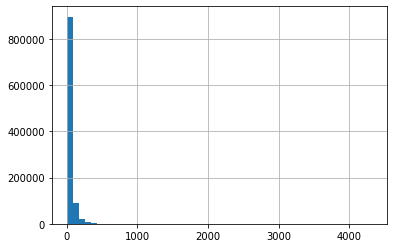

In [22]:
log.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).toPandas()['num_items'].hist(bins=50)

In [23]:
log.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).describe().show()

+-------+--------------------+-----------------+
|summary|             user_id|        num_items|
+-------+--------------------+-----------------+
|  count|             1019318|          1019318|
|   mean|                null|44.92719641956681|
| stddev|                null|54.91109265088129|
|    min|00000b72200188206...|                3|
|    max|fffff9534445f481b...|             4316|
+-------+--------------------+-----------------+



In [24]:
long_hist_users = log.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).filter(sf.col('num_items') > 14).select('user_id')
long_hist_users.count()


777701

In [25]:
%%time
log = log.join(long_hist_users.sample(0.5), on='user_id')

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 46.2 ms


In [27]:
log.cache()
get_log_info(log)

'total lines: 21519419, total users: 388611, total items: 348828'

### 0.2. Split

Let's take 2000 users and 5 interactions for each user to the test part. It is enough to show difference in speed between direct predict and predict with ANN search.

In [29]:
from replay.splitters import UserSplitter

splitter = UserSplitter(
    drop_cold_items=True,
    drop_cold_users=True,
    item_test_size=K,
    user_test_size=500,
    seed=SEED,
    shuffle=True
)
train, test = splitter.split(log)
(
    train.count(), 
    test.count()
)

(21516919, 2490)

In [30]:
train.write.parquet(path='train_ann_msd.parquet', mode='overwrite')
test.write.parquet(path='test_ann_msd.parquet', mode='overwrite')

In [11]:
train = spark.read.parquet('train_ann_msd.parquet')
test = spark.read.parquet('test_ann_msd.parquet')

## 1. Models training
We will train ALS model and get direct prediction for 2 cases:
- with filtering items seen in user history
- without filtering items seen in user history

#### ALS

In [20]:
from replay.models import ALSWrap
from replay.model_handler import save, load

In [32]:
%%time
als = ALSWrap(rank=256, seed=SEED)
als.fit(log=train)

CPU times: user 20.8 s, sys: 3.85 s, total: 24.6 s
Wall time: 1h 11min 27s


In [33]:
save(als, 'als_msd')

In [34]:
%%time
predict = als.predict(log=train, k=K, users=test.select('user_id').distinct(), filter_seen_items=True)
predict.cache()
predict.count()

CPU times: user 48.7 s, sys: 18.7 s, total: 1min 7s
Wall time: 20min 48s


2500

In [35]:
%%time
predict_seen = als.predict(log=train, k=K, users=test.select('user_id').distinct(), filter_seen_items=False)
predict_seen.cache()
predict_seen.count()

CPU times: user 48.7 s, sys: 19.6 s, total: 1min 8s
Wall time: 20min 35s


2500

Direct prediction takes about 7 minutes and time increases dramatically with the number of users / items.

In [36]:
predict_seen.write.parquet(path='./als_pred_seen_to_compare_with_ann_msd.parquet', mode='overwrite')
predict.write.parquet(path='./als_pred_to_compare_with_ann_msd.parquet', mode='overwrite')

In [13]:
predict_seen = spark.read.parquet('./als_pred_seen_to_compare_with_ann_msd.parquet')
predict = spark.read.parquet('./als_pred_to_compare_with_ann_msd.parquet')

## 2. Evaluate prediction quality

In [76]:
from replay.metrics import Coverage, HitRate, NDCG, MAP
from replay.experiment import Experiment

In [77]:
prediction_quality = Experiment(test, {NDCG(): K,
                            MAP() : K,
                            HitRate(): [1, K],
                            Coverage(train): K
                           })

In [17]:
%%time
prediction_quality.add_result("ALS_pred_with_seen", predict_seen)
prediction_quality.add_result("ALS_pred_filter_seen", predict)
prediction_quality.results.sort_values('NDCG@5', ascending=False)

CPU times: user 163 ms, sys: 49.1 ms, total: 212 ms
Wall time: 17.9 s


,Coverage@5,HitRate@1,HitRate@5,MAP@5,NDCG@5
ALS_pred_filter_seen,0.003569,0.134,0.302,0.05688,0.094531
ALS_pred_with_seen,0.003111,0.034,0.156,0.01884,0.036709


# 3. NMSLIB

Let's get user's and item's vectors from als model and build ann index.

In [18]:
# !pip install --no-binary :all: nmslib

In [50]:
import nmslib
import numpy as np
import pandas as pd

import pyspark.sql.functions as sf
from pyspark.sql import Window

from replay.utils import get_top_k_recs


Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [21]:
als = load('./als_msd')

In [15]:
train = spark.read.parquet('train_ann_msd.parquet')
test = spark.read.parquet('test_ann_msd.parquet')
predict = spark.read.parquet('./als_pred_to_compare_with_ann_msd.parquet')
predict_seen = spark.read.parquet('./als_pred_seen_to_compare_with_ann_msd.parquet')

In [27]:
def get_numpy_ids_vectors_from_als(id_vector_spark_df, id_name='item_id', vector_col_name='item_factors'):
    vectors = id_vector_spark_df.toPandas()
    ids = vectors[id_name].to_numpy()
    vectors = vectors[vector_col_name].to_numpy()
    return vectors, ids

In [28]:
%%time
user_vectors, _ = als.get_features(test.select('user_id').distinct())
user_vectors_np, user_ids_np = get_numpy_ids_vectors_from_als(user_vectors, id_name='user_id', vector_col_name='user_factors')

CPU times: user 17 s, sys: 5.51 s, total: 22.5 s
Wall time: 43 s


In [29]:
%%time
item_vectors, _ = als.get_features(train.select('item_id').distinct())
item_vectors_np, item_ids_np = get_numpy_ids_vectors_from_als(item_vectors, id_name='item_id', vector_col_name='item_factors')

CPU times: user 15.1 s, sys: 4.66 s, total: 19.7 s
Wall time: 55.2 s


Let's build index on item vectors and search for nearest for the user vectors from test with negative dot product distance measure.

## index with default parameters
Using hnsw index from nmslib as is

In [25]:
%%time
index = nmslib.init(method='hnsw', space='negdotprod', data_type=nmslib.DataType.DENSE_VECTOR)
index.addDataPointBatch(data=np.stack(item_vectors_np))
index.createIndex()

CPU times: user 8min 13s, sys: 26.5 s, total: 8min 39s
Wall time: 14.6 s


In [24]:
def get_neighbours(index, vectors, user_ids_list, item_ids_list, k):
    """
    - find nearest items based on user vector
    - convert to spark and process columns to get `user_id, item_id, relevance` columns
    - replace item numbers in index with item ids
    """
    neighbours = index.knnQueryBatch(np.stack(vectors), k=k)
    pd_res = pd.DataFrame(neighbours, columns=['item_idx', 'distance'])
    pd_res['user_id'] = user_ids_list
    spark_res = spark.createDataFrame(pd_res)
    spark_res = spark_res.withColumn('zip_exp', sf.explode(sf.arrays_zip('item_idx', 'distance'))).select('user_id', 'zip_exp')
    spark_res = spark_res.withColumn('item_idx', sf.col('zip_exp.item_idx'))
    spark_res = spark_res.withColumn('distance', sf.col('zip_exp.distance'))
    spark_res = (spark_res.withColumn('relevance',  sf.lit(-1.) * sf.col('distance'))
                 .select('user_id', 'item_idx', 'relevance')
                )
    ids_mapping = spark.createDataFrame(list(zip(range(len(list(item_ids_list))),
                                                 list(item_ids_list))),
                                        schema="item_idx int, item_id string")
    spark_res = spark_res.join(ids_mapping, on='item_idx').drop('item_idx').orderBy('user_id')
    return spark_res

In [51]:
def filter_seen(log, pred, k, id_type='id'):
    """
    filter items seen in log and leave top-k most relevant
    """
    
    user_id = 'user_' + id_type
    item_id = 'item_' + id_type
    num_of_seen = (
            log.groupBy(user_id)
            .agg(sf.count(item_id).alias("seen_count"))
        )


    max_seen = num_of_seen.select(sf.max("seen_count")).collect()[0][0]

    recs = pred.withColumn(
        "temp_rank",
        sf.row_number().over(
            Window.partitionBy(user_id).orderBy(
                sf.col("relevance").desc()
            )
        ),
    ).filter(sf.col("temp_rank") <= sf.lit(max_seen + k))
    

    
    recs = (
        recs.join(num_of_seen, on=user_id, how="left")
        .fillna(0)
        .filter(
            sf.col("temp_rank") <= sf.col("seen_count") + sf.lit(k)
        )
        .drop("temp_rank", "seen_count")
    )
    
    recs = recs.join(log, on=[user_id, item_id], how="anti")
    return get_top_k_recs(recs, k, id_type=id_type)

In [54]:
max_items_to_retrieve = train.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).select(sf.max('num_items')).collect()[0][0]
max_items_to_retrieve

1545

We have maximum of more than 1000 seen items per user, and it is a lot, as to achieve proper quality we will need to retrieve 1545 + K items per users. Will take. There is a tradeoff between index construction/retrieval time and size and retrieval quality. Read about algorithm parameters and tuning [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).

In [33]:
%%time
ann_res_k = get_neighbours(index, user_vectors_np, user_ids_np, item_ids_np, K)
ann_res_k.count()

CPU times: user 1.21 s, sys: 14.2 ms, total: 1.22 s
Wall time: 2.16 s


2500

In [38]:
%%time
ann_res = get_neighbours(index, user_vectors_np, user_ids_np, item_ids_np, K + max_items_to_retrieve)
ann_res = filter_seen(train, ann_res, K)
ann_res.count()

CPU times: user 1.29 s, sys: 53 ms, total: 1.34 s
Wall time: 12.6 s


2500

In [39]:
index.saveIndex('index_msd')

In [40]:
! du -sh ./index_msd

393M	./index_msd


Prediction with ANN is significantly faster (13 seconds with 21 minutes)

#### Predicting for more users
evaluating time on prediction for 100'000 users

In [41]:
%%time
user_vectors_big, _ = als.get_features(train.select('user_id').distinct().sample(0.3))
user_vectors_big.count()

CPU times: user 17 s, sys: 5.94 s, total: 22.9 s
Wall time: 51.5 s


116378

In [42]:
%%time
user_vectors_np_big, user_ids_np_big = get_numpy_ids_vectors_from_als(user_vectors_big, id_name='user_id', vector_col_name='user_factors')
ann_res_big = get_neighbours(index, user_vectors_np_big, user_ids_np_big, item_ids_np, K + max_items_to_retrieve)
ann_res_big = filter_seen(train, ann_res_big, K)
ann_res_big.count()

CPU times: user 34.9 s, sys: 5.46 s, total: 40.3 s
Wall time: 52.7 s


581890

### Index precision evaluation

Let's compare ann results with ground truths (model prediction) for two settings:
    - selecting top-k (no seen items filtering)
    - selecting top-k + maximal number of seen items and post-filtering

We can expect better quality on the first task. 

In [43]:
from replay.metrics import Precision
from replay.experiment import Experiment

In [44]:
metrics_filter_seen = Experiment(predict, {Precision(): K})
metrics_with_seen = Experiment(predict_seen, {Precision(): K})

In [45]:
%%time
metrics_with_seen.add_result("Default_HNSW", ann_res_k)
metrics_with_seen.results

CPU times: user 58.9 ms, sys: 4.6 ms, total: 63.5 ms
Wall time: 4.08 s


,Precision@5
Default_HNSW,0.8228


In [46]:
metrics_filter_seen.add_result("Default_HNSW", ann_res)
metrics_filter_seen.results

,Precision@5
Default_HNSW,0.8352


In [47]:
%%time
prediction_quality.add_result("HNSW_pred_with_seen", ann_res_k)
prediction_quality.add_result("HNSW_pred_filter_seen", ann_res)
prediction_quality.results.sort_values('NDCG@5', ascending=False)

CPU times: user 343 ms, sys: 162 ms, total: 506 ms
Wall time: 54.8 s


,Coverage@5,HitRate@1,HitRate@5,MAP@5,NDCG@5
ALS_pred_filter_seen,0.003569,0.134,0.302,0.056880,0.094531
HNSW_pred_filter_seen,0.003807,0.134,0.288,0.056240,0.091713
HNSW_pred_with_seen,0.003337,0.038,0.154,0.019987,0.038041
ALS_pred_with_seen,0.003111,0.034,0.156,0.018840,0.036709


## index with more complex parameters

Lets increase parameters to improve retrieval quality: 
- M defines the maximum number of neighbors in the zero and above-zero layers
- ef defines the number of vertex to try on each level to find nearest

See example of index building with nmslib [here](https://github.com/nmslib/nmslib/blob/master/python_bindings/notebooks/search_vector_dense_optim.ipynb)

In [48]:
%%time
index = nmslib.init(method='hnsw', space='negdotprod', data_type=nmslib.DataType.DENSE_VECTOR)
index.addDataPointBatch(data=np.stack(item_vectors_np))
index.createIndex(index_params={'efConstruction':1000, 'M':64})

CPU times: user 2h 29min 45s, sys: 1min 53s, total: 2h 31min 38s
Wall time: 4min 10s


In [49]:
query_time_params = {'efSearch': 1000}
index.setQueryTimeParams(query_time_params)

In [50]:
%%time
ann_res_k = get_neighbours(index, user_vectors_np, user_ids_np, item_ids_np, K)
ann_res_k.count()

CPU times: user 18.5 s, sys: 91.7 ms, total: 18.5 s
Wall time: 2.67 s


2500

In [51]:
%%time
ann_res = get_neighbours(index, user_vectors_np, user_ids_np, item_ids_np, K + max_items_to_retrieve)
ann_res = filter_seen(train, ann_res, K)
ann_res.count()

CPU times: user 19.5 s, sys: 199 ms, total: 19.7 s
Wall time: 9.02 s


2500

In [52]:
index.saveIndex('big_index_mds')

In [53]:
! du -sh ./big_index_mds

521M	./big_index_mds


#### Predicting for more users

In [54]:
%%time
ann_res_big = get_neighbours(index, user_vectors_np_big, user_ids_np_big, item_ids_np, K + max_items_to_retrieve)
ann_res_big = filter_seen(train, ann_res_big, K)
ann_res_big.count()

CPU times: user 49min 29s, sys: 47.4 s, total: 50min 17s
Wall time: 6min 33s


581890

### Index precision evaluation

In [55]:
%%time
metrics_with_seen.add_result("tuned_HNSW", ann_res_k)
metrics_with_seen.results

CPU times: user 37.9 ms, sys: 31.1 ms, total: 69 ms
Wall time: 5.82 s


,Precision@5
Default_HNSW,0.8228
tuned_HNSW,1.0000


In [56]:
metrics_filter_seen.add_result("tuned_HNSW", ann_res)
metrics_filter_seen.results

,Precision@5
Default_HNSW,0.8352
tuned_HNSW,0.9984


In [57]:
%%time
prediction_quality.add_result("tuned_HNSW_pred_with_seen", ann_res_k)
prediction_quality.add_result("tuned_HNSW_pred_filter_seen", ann_res)
prediction_quality.results.sort_values('NDCG@5', ascending=False)

CPU times: user 247 ms, sys: 219 ms, total: 466 ms
Wall time: 37.2 s


,Coverage@5,HitRate@1,HitRate@5,MAP@5,NDCG@5
ALS_pred_filter_seen,0.003569,0.134,0.302,0.056880,0.094531
tuned_HNSW_pred_filter_seen,0.003575,0.134,0.300,0.056780,0.094239
HNSW_pred_filter_seen,0.003807,0.134,0.288,0.056240,0.091713
HNSW_pred_with_seen,0.003337,0.038,0.154,0.019987,0.038041
ALS_pred_with_seen,0.003111,0.034,0.156,0.018840,0.036709
tuned_HNSW_pred_with_seen,0.003111,0.034,0.156,0.018840,0.036709


Index quality increased and achieved precision = 1. 
You can try to use hnsw, faiss, annoy of any other ANN library to build you index and get faster prediction for vector models.

# MlLIb LSH
Locality Sensitive Hashing from pyspark MlLib.
Read MlLib documentation for [BucketedRandomProjectionLSH](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.BucketedRandomProjectionLSH.html#pyspark.ml.feature.BucketedRandomProjectionLSH) and [fitted BucketedRandomProjectionLSH model](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.BucketedRandomProjectionLSHModel.html#pyspark.ml.feature.BucketedRandomProjectionLSHModel)

Advantage of BucketedRandomProjectionLSH is it uses spark and does not require data collection to driver and conversion to python. Disadvantages are the complexity of parameters selection and only one distance measure, euclidean distance, which is not connected with the dot product used in ALS.

In [45]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

In [34]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

### Convert user and item ids to integer and save

In [2]:
from pyspark.ml.feature import IndexToString, StringIndexer

In [17]:
%%time

user_indexer = StringIndexer(
    inputCol="user_id", outputCol="user_idx"
).fit(log.select('user_id').distinct())
item_indexer = StringIndexer(
    inputCol="item_id", outputCol="item_idx"
).fit(log.select('item_id').distinct())

inv_user_indexer = IndexToString(
    inputCol="user_idx",
    outputCol="user_id",
    labels=user_indexer.labels,
)
inv_item_indexer = IndexToString(
    inputCol="item_idx",
    outputCol="item_id",
    labels=item_indexer.labels,
)

CPU times: user 7.55 s, sys: 652 ms, total: 8.2 s
Wall time: 37.6 s


In [35]:
%%time
user_vectors_brp = (user_indexer.transform(user_vectors)
                    .withColumn('user_idx', sf.col('user_idx').cast("int"))
                    .drop('user_id')
                    .withColumnRenamed('user_idx', 'id')
                    .withColumn('features', list_to_vector_udf(sf.col('user_factors')))
                    .drop('user_factors')
                   )
item_vectors_brp = (item_indexer.transform(item_vectors)
                    .withColumn('item_idx', sf.col('item_idx').cast("int"))
                    .drop('item_id')
                    .withColumnRenamed('item_idx', 'id')
                    .withColumn('features', list_to_vector_udf(sf.col('item_factors')))
                    .drop('item_factors')
                   )

CPU times: user 33.5 ms, sys: 20.5 ms, total: 54 ms
Wall time: 132 ms


In [36]:
%%time
user_vectors_brp.write.parquet(path='user_vectors_lsh.parquet', mode='overwrite')
item_vectors_brp.write.parquet(path='item_vectors_lsh.parquet', mode='overwrite')

CPU times: user 93.7 ms, sys: 13.1 ms, total: 107 ms
Wall time: 54.4 s


In [37]:
user_vectors_brp=spark.read.parquet('user_vectors_lsh.parquet')
item_vectors_brp=spark.read.parquet('item_vectors_lsh.parquet')

In [38]:
user_vectors_brp.show(2)

+------+--------------------+
|    id|            features|
+------+--------------------+
|609619|[-0.1389203965663...|
|864912|[0.01281957328319...|
+------+--------------------+
only showing top 2 rows



### Normalize vectors for better index performance and easier selection of bucketLength

In [41]:
import pyspark.sql.types as st
from pyspark.ml.linalg import DenseVector

In [42]:
@sf.udf(returnType=VectorUDT())
def norm_vector(first: DenseVector) -> DenseVector:
    return first * (1/float(first.dot(first))) ** 0.5

In [43]:
item_vectors_brp_n = item_vectors_brp.withColumn('features', norm_vector(sf.col('features')))
user_vectors_brp_n = user_vectors_brp.withColumn('features', norm_vector(sf.col('features')))
item_vectors_brp_n.cache()
user_vectors_brp_n.cache()
item_vectors_brp_n.count()
user_vectors_brp_n.count()

500

[MlLib documentation](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.BucketedRandomProjectionLSHModel.html#pyspark.ml.feature.BucketedRandomProjectionLSHModel) says that the number of buckets will be (max L2 norm of input vectors) / bucketLength.

    
It is important to properly choose the bucketLength and other hyperparameters otherwise you will experience either lack of neighbours or significant performance degradation or both.

Here is example of bucketLength selection:
Assuming we want to have at least 10'000 neighbours for each item. We have 348818 items and if we take 25 buckets, the required number of neighbours will be achieved with overhead (assuming uniform distribution, which is not guaranteed). Max L2 norm of input vectors is 1, thus the bucketLength may be 1 / 25 = 0.04.

Important fit parameters are bucketLength (the greater, the more candidates to neighbours, but leads to performance degradation) and numHashTables (the greater the better accuracy).

### Initial parameters

In [46]:
%%time
brp = BucketedRandomProjectionLSH(inputCol='features', seed=SEED, bucketLength=0.04, numHashTables=1)
brp_model = brp.fit(item_vectors_brp_n)

CPU times: user 6.21 ms, sys: 4.12 ms, total: 10.3 ms
Wall time: 10.4 s


In [72]:
def convert_back(inv_user_indexer, inv_item_indexer, log):
    res = log
    if "user_idx" in log.columns:
        res = (
            inv_user_indexer.transform(res)
            .drop("user_idx")
            .withColumn("user_id", sf.col("user_id").cast(train.schema["user_id"].dataType))
        )
    if "item_idx" in log.columns:
        res = (
            inv_item_indexer.transform(res)
            .drop("item_idx")
            .withColumn("item_id", sf.col("item_id").cast(train.schema["item_id"].dataType))
        )
    return res

In [69]:
def get_pred_from_brp(fitted_brp):
    test_all = fitted_brp.approxSimilarityJoin(user_vectors_brp_n, 
                                          item_vectors_brp_n,
                                          threshold = 1.,
                                          distCol="EuclideanDistance").select(
    sf.col("datasetA.id").alias("user_idx"),
    sf.col("datasetB.id").alias("item_idx"),
    (sf.col("EuclideanDistance") * sf.lit(-1)).alias('relevance'))
    
    test_res = test_all.withColumn("temp_rank",
        sf.row_number().over(
            Window.partitionBy("user_idx").orderBy(
                sf.col("relevance").desc()
            )
        )
    ).filter(sf.col("temp_rank") <= sf.lit(max_items_to_retrieve + K))

    test_res = convert_back(inv_user_indexer, inv_item_indexer, test_res)
    test_res.cache()
    test_res_filter = get_top_k_recs(filter_seen(train, test_res, K), K)
    test_res = get_top_k_recs(test_res, K)
    test_res.cache()
    test_res.count()
    return test_res_filter, test_res

In [ ]:
%%time
brp_pred_filtered, brp_pred = get_pred_from_brp(brp_model)

### Having a look at the prediction precision

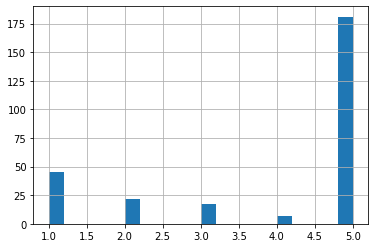

In [70]:
brp_pred_filtered.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).toPandas()['num_items'].hist(bins=20);

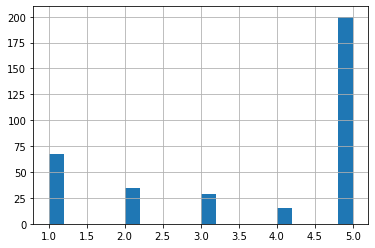

In [71]:
brp_pred.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).toPandas()['num_items'].hist(bins=20);

In [72]:
prediction_quality.add_result("LSH_with_seen_normed", brp_pred)
prediction_quality.add_result("LSH_filter_seen_normed", brp_pred_filtered)
prediction_quality.results.sort_values('NDCG@5', ascending=False)

,Coverage@5,HitRate@1,HitRate@5,MAP@5,NDCG@5
ALS_pred_filter_seen,0.003569,0.134,0.302,0.056880,0.094531
tuned_HNSW_pred_filter_seen,0.003575,0.134,0.300,0.056780,0.094239
HNSW_pred_filter_seen,0.003807,0.134,0.288,0.056240,0.091713
HNSW_pred_with_seen,0.003337,0.038,0.154,0.019987,0.038041
ALS_pred_with_seen,0.003111,0.034,0.156,0.018840,0.036709
tuned_HNSW_pred_with_seen,0.003111,0.034,0.156,0.018840,0.036709
LSH_filter_seen_normed,0.002890,0.048,0.082,0.016060,0.027026
LSH_with_seen_normed,0.003314,0.026,0.070,0.008913,0.017258


In [73]:
%%time
metrics_with_seen.add_result("LSH_normed", brp_pred)
metrics_with_seen.results

CPU times: user 29.3 ms, sys: 22.4 ms, total: 51.7 ms
Wall time: 4.51 s


,Precision@5
Default_HNSW,0.8228
tuned_HNSW,1.0000
LSH_normed,0.1985


In [74]:
metrics_filter_seen.add_result("LSH_normed", brp_pred_filtered)
metrics_filter_seen.results

,Precision@5
Default_HNSW,0.8352
tuned_HNSW,0.9984
LSH_normed,0.1025


#### Predicting for more users

In [75]:
user_vectors_brp_big = (user_indexer.transform(user_vectors_big)
                    .withColumn('user_idx', sf.col('user_idx').cast("int"))
                    .drop('user_id')
                    .withColumnRenamed('user_idx', 'id')
                    .withColumn('features', list_to_vector_udf(sf.col('user_factors')))
                    .drop('user_factors')
                   )

user_vectors_brp_big.cache()
user_vectors_brp_big.count()

116378

### More tables and wider buckets

In [76]:
%%time
brp = BucketedRandomProjectionLSH(inputCol='features', seed=SEED, bucketLength=0.1, numHashTables=5)
brp_model = brp.fit(item_vectors_brp_n)

CPU times: user 4.62 ms, sys: 83 µs, total: 4.71 ms
Wall time: 44.5 ms


In [77]:
%%time
brp_pred_filtered, brp_pred = get_pred_from_brp(brp_model)

CPU times: user 27.2 s, sys: 9.17 s, total: 36.4 s
Wall time: 1min 44s


### Having a look at the prediction precision

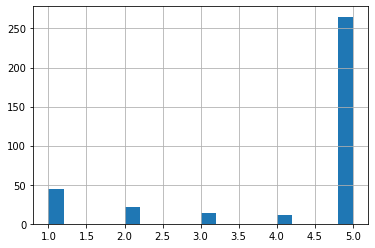

In [78]:
brp_pred_filtered.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).toPandas()['num_items'].hist(bins=20);

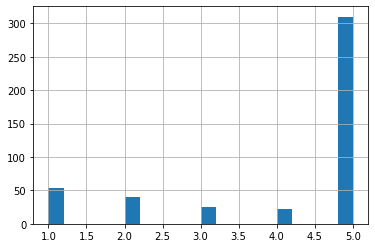

In [79]:
brp_pred.groupBy('user_id').agg(sf.count('item_id').alias('num_items')).toPandas()['num_items'].hist(bins=20);

As we can see we did not get enough items for some users. The decision could be wider buckets of greater threshold in join, but this could slow down an inference significantly.

In [80]:
prediction_quality.add_result("LSH_with_seen_normed_better", brp_pred)
prediction_quality.add_result("LSH_filter_seen_normed_better", brp_pred_filtered)
prediction_quality.results.sort_values('NDCG@5', ascending=False)

,Coverage@5,HitRate@1,HitRate@5,MAP@5,NDCG@5
ALS_pred_filter_seen,0.003569,0.134,0.302,0.056880,0.094531
tuned_HNSW_pred_filter_seen,0.003575,0.134,0.300,0.056780,0.094239
HNSW_pred_filter_seen,0.003807,0.134,0.288,0.056240,0.091713
LSH_filter_seen_normed_better,0.003873,0.086,0.182,0.034097,0.057568
HNSW_pred_with_seen,0.003337,0.038,0.154,0.019987,0.038041
ALS_pred_with_seen,0.003111,0.034,0.156,0.018840,0.036709
tuned_HNSW_pred_with_seen,0.003111,0.034,0.156,0.018840,0.036709
LSH_filter_seen_normed,0.002890,0.048,0.082,0.016060,0.027026
LSH_with_seen_normed_better,0.004349,0.016,0.112,0.010390,0.022711
LSH_with_seen_normed,0.003314,0.026,0.070,0.008913,0.017258


In [81]:
%%time
metrics_with_seen.add_result("LSH_normed_better", brp_pred)
metrics_with_seen.results.sort_values('Precision@5', ascending=False)

CPU times: user 38.1 ms, sys: 9.09 ms, total: 47.2 ms
Wall time: 5.4 s


,Precision@5
tuned_HNSW,1.0000
Default_HNSW,0.8228
LSH_normed_better,0.3595
LSH_normed,0.1985


In [82]:
metrics_filter_seen.add_result("LSH_normed_better", brp_pred_filtered)
metrics_filter_seen.results.sort_values('Precision@5', ascending=False)

,Precision@5
tuned_HNSW,0.9984
Default_HNSW,0.8352
LSH_normed_better,0.1946
LSH_normed,0.1025
